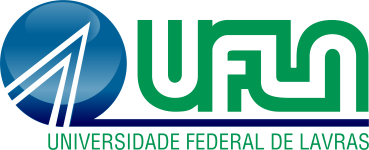

# Parallel Simulated Annealing

Trabalho Final da disciplina **Programação Paralela e Concorrente** (2023/1).


**Professora:** Marluce Rodrigues Pereira

**Alunos:**

- João Gabriel Kondarzewski Zanella - 202020091
- Henrique Curi de Miranda - 202020087
- Victor Gonçalves Lima - 202020775

O trabalho tem como objeto paralelizar o algorimo de otimização ***Simulated Annealing*** e analizar os resutados obtidos.

## Importações

In [ ]:
from src.funcoes_auxiliares import gerar_itens_aleatorios, gerar_mochila_aleatoria
from src.funcoes_plotagem import plotar_itens

## Dispersão dos itens

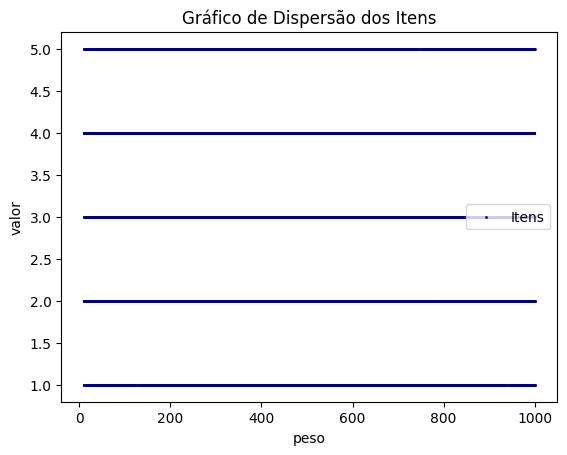

In [5]:
numero_itens = 10000
valor_minimo = 1
valor_maximo = 5
tipo_valor="int"
peso_minimo = 10.0
peso_maximo = 1000.0
tipo_peso = "float"
itens = gerar_itens_aleatorios(numero_itens=numero_itens,
                               valor_minimo=valor_minimo,
                               valor_maximo=valor_maximo,
                               tipo_valor=tipo_valor,
                               peso_minimo=peso_minimo,
                               peso_maximo=peso_maximo,
                               tipo_peso=tipo_peso)

plotar_itens(itens)

## Solução aleatória

Total de itens na mochila: 24
Valor total na mochila: 68
Peso total na mochila: 9995.44414881477


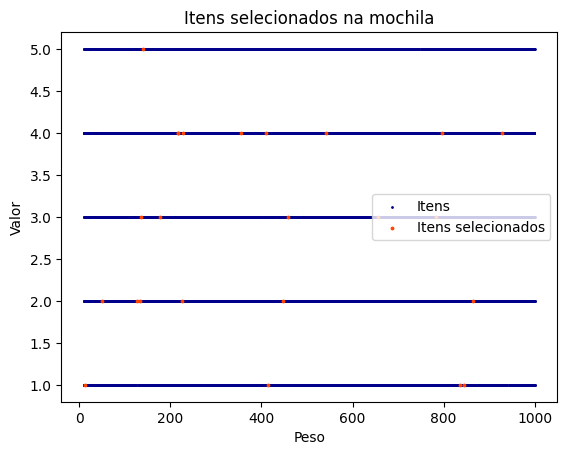

In [10]:
capacidade_das_mochilas = 10000.0 # 10 toneladas
mochila_inicial = gerar_mochila_aleatoria(capacidade=capacidade_das_mochilas,
                                          itens=itens)
plotar_itens(itens, mochila_inicial)